In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load DGS10 and VIX data
dgs10 = pd.read_csv('data/DGS10.csv')
vix = pd.read_csv('data/VIXCLS.csv')

# Convert date columns to datetime
dgs10['observation_date'] = pd.to_datetime(dgs10['observation_date'])
vix['observation_date'] = pd.to_datetime(vix['observation_date'])

# Sort by date
dgs10 = dgs10.sort_values('observation_date').reset_index(drop=True)
vix = vix.sort_values('observation_date').reset_index(drop=True)

print("DGS10 data shape:", dgs10.shape)
print("DGS10 date range:", dgs10['observation_date'].min(), "to", dgs10['observation_date'].max())
print("\nVIX data shape:", vix.shape)
print("VIX date range:", vix['observation_date'].min(), "to", vix['observation_date'].max())
print("\nDGS10 first few rows:")
print(dgs10.head())

DGS10 data shape: (5594, 2)
DGS10 date range: 2004-09-01 00:00:00 to 2026-02-09 00:00:00

VIX data shape: (5504, 2)
VIX date range: 2005-01-03 00:00:00 to 2026-02-05 00:00:00

DGS10 first few rows:
  observation_date  DGS10
0       2004-09-01   4.13
1       2004-09-02   4.20
2       2004-09-03   4.30
3       2004-09-06    NaN
4       2004-09-07   4.26


# Forward Fill missing NaN data

In [3]:
dgs10 = dgs10.ffill()
vix = vix.ffill()
print(dgs10.isna().sum())
print(vix.isna().sum())

observation_date    0
DGS10               0
dtype: int64
observation_date    0
VIXCLS              0
dtype: int64


In [4]:
# Calculate 3-month percentage change in DGS10
# 3-month = approximately 13 weeks = 65 trading days (approx)
dgs10['DGS10_3m_pct_change'] = dgs10['DGS10'].pct_change(periods=65)

# Display statistics
print("DGS10 3-Month Percentage Change Statistics:")
print(dgs10['DGS10_3m_pct_change'].describe())
print("\nMissing values in DGS10_3m_pct_change:", dgs10['DGS10_3m_pct_change'].isna().sum())
print("\nSample of DGS10 with 3-month change:")
print(dgs10[['observation_date', 'DGS10', 'DGS10_3m_pct_change']].iloc[65:75])

DGS10 3-Month Percentage Change Statistics:
count    5529.000000
mean        0.017872
std         0.189238
min        -0.704918
25%        -0.088000
50%         0.000000
75%         0.097143
max         0.870968
Name: DGS10_3m_pct_change, dtype: float64

Missing values in DGS10_3m_pct_change: 65

Sample of DGS10 with 3-month change:
   observation_date  DGS10  DGS10_3m_pct_change
65       2004-12-01   4.38             0.060533
66       2004-12-02   4.40             0.047619
67       2004-12-03   4.27            -0.006977
68       2004-12-06   4.24            -0.013953
69       2004-12-07   4.23            -0.007042
70       2004-12-08   4.14            -0.009569
71       2004-12-09   4.19            -0.007109
72       2004-12-10   4.16            -0.007160
73       2004-12-13   4.16             0.000000
74       2004-12-14   4.14            -0.002410


In [5]:
#Drop dates before 2005
dgs10 = dgs10[dgs10['observation_date'] >= '2005-01-03'].reset_index(drop=True)
print(dgs10.isna().sum())
dgs10.head()

observation_date       0
DGS10                  0
DGS10_3m_pct_change    0
dtype: int64


,observation_date,DGS10,DGS10_3m_pct_change
0,2005-01-03,4.23,0.009547
1,2005-01-04,4.29,0.026316
2,2005-01-05,4.29,0.014184
3,2005-01-06,4.29,0.007042
4,2005-01-07,4.29,0.033735


In [6]:
print(vix.shape)
print(dgs10.shape)

(5504, 2)
(5506, 3)


In [7]:
# Merge DGS10 and VIX on date
market_data = dgs10[['observation_date', 'DGS10', 'DGS10_3m_pct_change']].copy()
market_data.rename(columns={'observation_date': 'date'}, inplace=True)

vix_subset = vix[['observation_date', 'VIXCLS']].copy()
vix_subset.rename(columns={'observation_date': 'date'}, inplace=True)

# Merge on date
market_data = market_data.merge(vix_subset, on='date', how='inner')

# Remove rows with NaN values in DGS10_3m_pct_change
market_data = market_data.dropna(subset=['DGS10_3m_pct_change'])

# Reset index
market_data = market_data.reset_index(drop=True)

print("Combined market data shape:", market_data.shape)
print("\nMarket data date range:", market_data['date'].min(), "to", market_data['date'].max())
print("\nCombined data summary:")
print(market_data[['date', 'VIXCLS', 'DGS10_3m_pct_change']].describe())
print("\nFirst few rows of combined data:")
print(market_data.isna().sum())
market_data = market_data.dropna()
market_data = market_data.reset_index(drop=True)
print(market_data.isna().sum())

market_data.head()

Combined market data shape: (5504, 4)

Market data date range: 2005-01-03 00:00:00 to 2026-02-05 00:00:00

Combined data summary:
                                date       VIXCLS  DGS10_3m_pct_change
count                           5504  5504.000000          5504.000000
mean   2015-07-21 07:12:12.558139392    19.101414             0.017847
min              2005-01-03 00:00:00     9.140000            -0.704918
25%              2010-04-12 18:00:00    13.430000            -0.088863
50%              2015-07-21 12:00:00    16.690000             0.000000
75%              2020-10-28 06:00:00    22.010000             0.097715
max              2026-02-05 00:00:00    82.690000             0.870968
std                              NaN     8.597177             0.189657

First few rows of combined data:
date                   0
DGS10                  0
DGS10_3m_pct_change    0
VIXCLS                 0
dtype: int64
date                   0
DGS10                  0
DGS10_3m_pct_change    0
VIXCLS   

,date,DGS10,DGS10_3m_pct_change,VIXCLS
0,2005-01-03,4.23,0.009547,14.08
1,2005-01-04,4.29,0.026316,13.98
2,2005-01-05,4.29,0.014184,14.09
3,2005-01-06,4.29,0.007042,13.58
4,2005-01-07,4.29,0.033735,13.49


# Data is clean and ready for clustering 

In [8]:
# Prepare features for clustering
features = market_data[['VIXCLS', 'DGS10_3m_pct_change']].values

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Original features shape:", features.shape)
fs_df = pd.DataFrame(features_scaled)
fs_df_new = fs_df.dropna().reset_index(drop=True)  # Reset index to match market_data
fs_df_new.isna().sum()
fs_df_new

Original features shape: (5504, 2)


,0,1
0,-0.584130,-0.043771
1,-0.595763,0.044656
2,-0.582967,-0.019315
3,-0.642294,-0.056976
4,-0.652764,0.083778
...,...,...
5499,-0.193269,0.098340
5500,-0.321229,0.110176
5501,-0.128125,0.137393
5502,-0.053675,0.057634


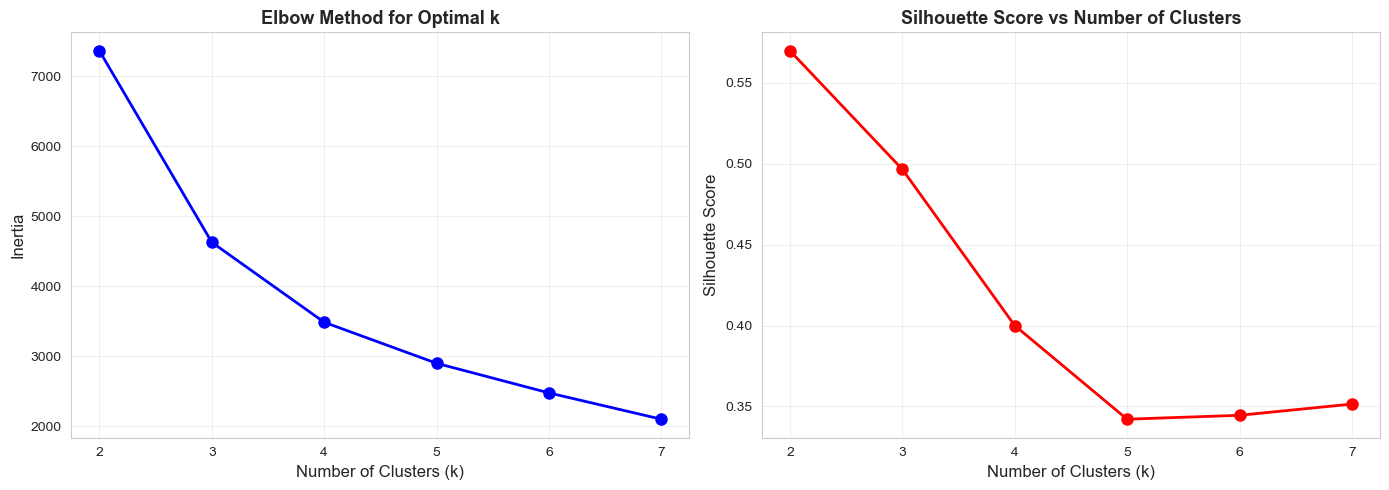

Elbow method results:
k=2: Inertia=7366.40, Silhouette Score=0.5697
k=3: Inertia=4628.03, Silhouette Score=0.4965
k=4: Inertia=3484.46, Silhouette Score=0.4000
k=5: Inertia=2897.87, Silhouette Score=0.3421
k=6: Inertia=2474.24, Silhouette Score=0.3445
k=7: Inertia=2097.78, Silhouette Score=0.3515


In [9]:
# Elbow method to find optimal k
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(fs_df_new)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(fs_df_new, kmeans_temp.labels_))

# Plot elbow method
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Elbow method results:")
for k, inertia, sil_score in zip(K_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.4f}")


K-Means Clustering with k=3
Cluster centers (original scale):
  Regime 0: VIX=16.58, DGS10_3m_pct_change=-0.0244
  Regime 1: VIX=41.81, DGS10_3m_pct_change=-0.2480
  Regime 2: VIX=21.50, DGS10_3m_pct_change=0.3270

Regime distribution:
regime
0    4229
1     375
2     900
Name: count, dtype: int64
        date  DGS10  DGS10_3m_pct_change  VIXCLS  regime
0 2005-01-03   4.23             0.009547   14.08       0
1 2005-01-04   4.29             0.026316   13.98       0
2 2005-01-05   4.29             0.014184   14.09       0
3 2005-01-06   4.29             0.007042   13.58       0
4 2005-01-07   4.29             0.033735   13.49       0


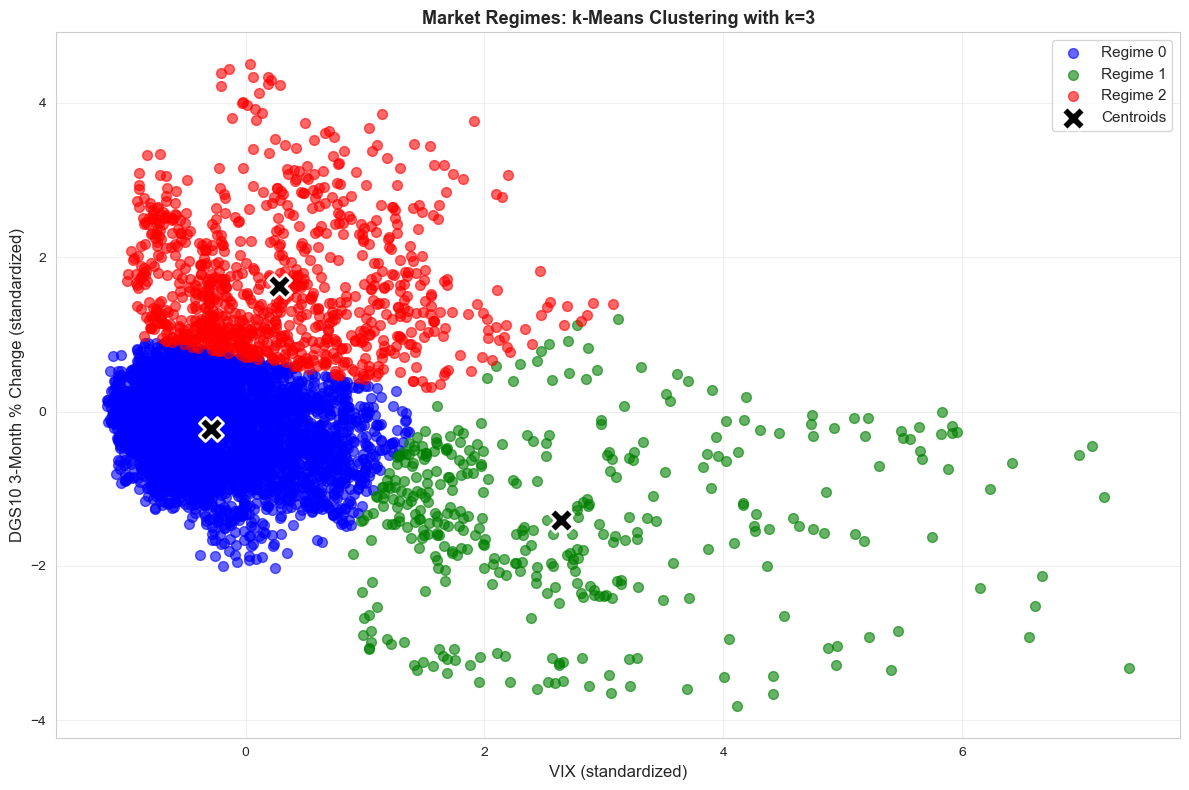

In [10]:
# Fit k-means with k=3 (calm, normal, stress regimes)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
market_data['regime'] = kmeans.fit_predict(fs_df_new.values)

# Get cluster centers in original scale
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

print(f"\nK-Means Clustering with k={optimal_k}")
print(f"Cluster centers (original scale):")
for i, center in enumerate(cluster_centers_original):
    print(f"  Regime {i}: VIX={center[0]:.2f}, DGS10_3m_pct_change={center[1]:.4f}")

print(f"\nRegime distribution:")
print(market_data['regime'].value_counts().sort_index())
print(market_data.head())

# Visualize the clustering
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']
for i in range(optimal_k):
    # Create a boolean mask - FIXED: Use direct filtering instead of loc with mask.index
    mask = market_data['regime'] == i
    
    # Extract the data points that belong to this regime
    # Use the boolean mask directly with fs_df_new, assuming they have the same length and order
    regime_data = fs_df_new[mask]
    
    # Plot using the first and second columns
    plt.scatter(regime_data.iloc[:, 0], regime_data.iloc[:, 1], 
               c=colors[i], label=f'Regime {i}', alpha=0.6, s=50)

# Plot cluster centers
plt.scatter(cluster_centers_scaled[:, 0], cluster_centers_scaled[:, 1], 
           c='black', marker='X', s=300, edgecolors='white', linewidths=2, label='Centroids')

plt.xlabel('VIX (standardized)', fontsize=12)
plt.ylabel('DGS10 3-Month % Change (standardized)', fontsize=12)
plt.title(f'Market Regimes: k-Means Clustering with k={optimal_k}', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Due to limits with data collection some 10dgs and VIX data was missing so we forward filled them with the next day to make sure our data set was complete we now have regime for each day for 20 years

In [11]:
market_data.to_csv("regime.csv", index=False)